RNN multiple features
weather history data

In [17]:
###-----------------
### Import Libraries
###-----------------
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

from sklearn.metrics import mean_squared_error

import tensorflow as tf
# from utils.helper import fn_plot_tf_hist

In [18]:
def fn_plot_tf_hist(hist_df):

    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: accuracy
            column 1: loss
            column 2: val_accuracy
            column 3: val_loss
            While plotting columns are accessed by index
            so that even if the column names are different it will not throw exceptions.
    '''

    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm

    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y4] == hist_df[y4].min()]

    ax = axes[0]

    hist_df.plot(y = [y2,y4], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = '{:s}: \n  train: {:6.4f}\n   test: {:6.4f}'
    txtstr = txtFmt.format(y2.capitalize(),
                           hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0] + offset), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3)

    ax.set_xlabel('Epochs')
    ax.set_ylabel(y2.capitalize())
    ax.set_title('Errors')
    ax.grid(True)
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y1, y3], ax = ax, colormap=CMAP)

    # little beautification
    txtFmt = '{:s}: \n  train: {:6.4f}\n  test:  {:6.4f}'
    txtstr = txtFmt.format(y1.capitalize(),
                           hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0]-offset), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow


    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3)

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.grid(True)
    ax.legend(loc = 'lower left')

    plt.tight_layout()

In [19]:
### ----------------------
### global variables
### ----------------------

import random

RANDOM_STATE = 24

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)


TEST_SIZE = 0.2
ALPHA = 0.001 # LEARNING RATE
EPOCHS = 30  # NUMBER OF ITERATIONS
BATCH_SIZE = 32                  # Default for Tensorflow

# input and output directories
inpDir = '../../input'
outDir = '../output'

params = {
    'legend.fontsize': 'medium',
    'figure.figsize': (10, 6),
    'axes.labelsize': 'medium',
    'axes.titlesize':'large',
    'xtick.labelsize':'medium',
    'ytick.labelsize':'medium'
}

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')

# Load Weather Data

In [20]:
fileName = 'weatherHistory.csv'
data_df = pd.read_csv(fileName)
data_df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [21]:
data_df['datetime'] = pd.to_datetime(data_df['Formatted Date'], utc = True)
data_df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary,datetime
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.,2006-03-31 22:00:00+00:00
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.,2006-03-31 23:00:00+00:00
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.,2006-04-01 00:00:00+00:00
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.,2006-04-01 01:00:00+00:00
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.,2006-04-01 02:00:00+00:00


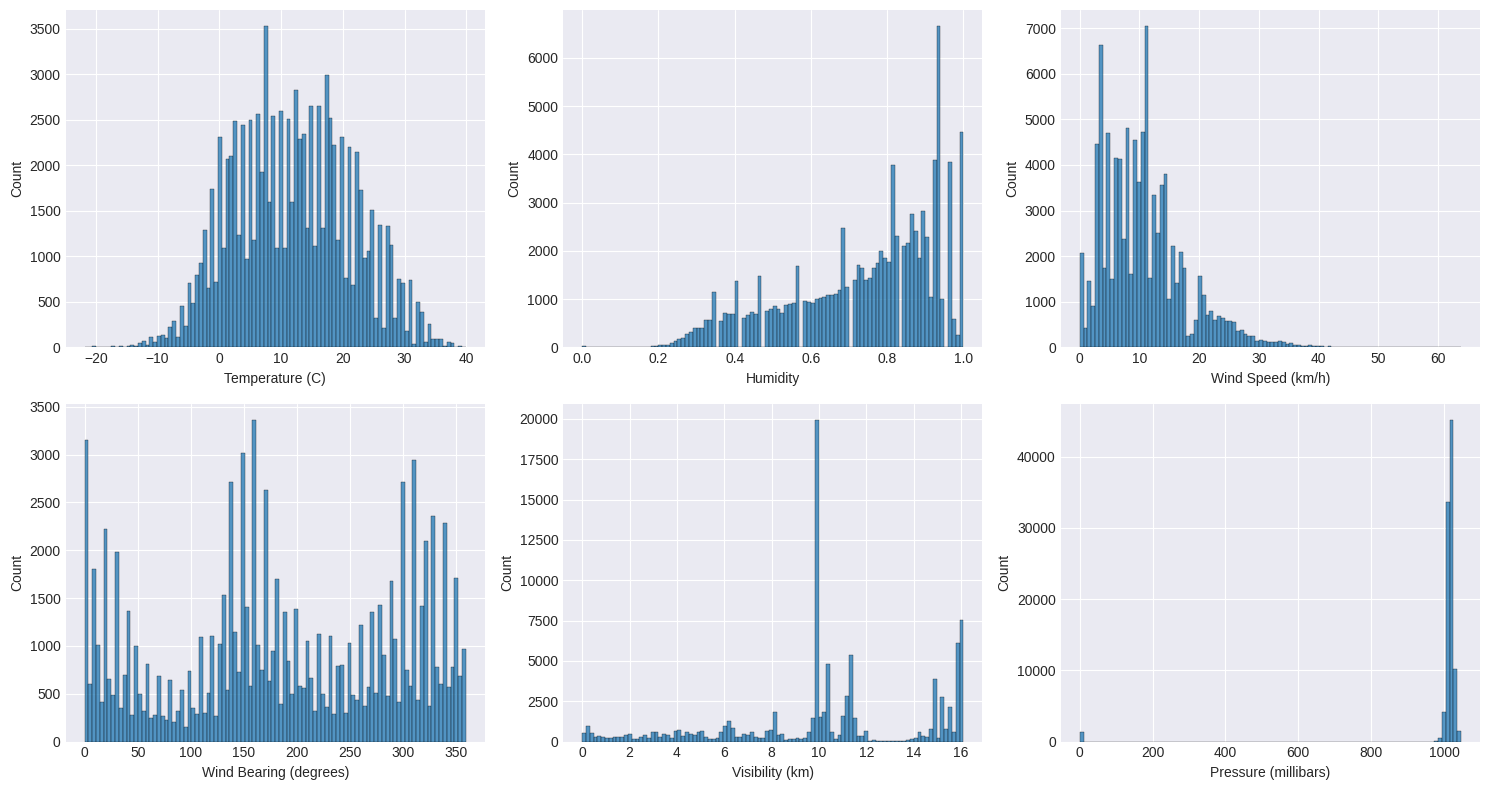

In [22]:
num_cols = ['Temperature (C)', 'Humidity',
            'Wind Speed (km/h)', 'Wind Bearing (degrees)',
            'Visibility (km)', 'Pressure (millibars)']

nbin = 100

fig, axes = plt.subplots(2, 3, figsize = (15, 8))

axes = axes.ravel()

for count, col in enumerate(num_cols):
    ax = axes[count]
    sns.histplot(data = data_df, x = col, ax = ax, bins = nbin)

plt.tight_layout()

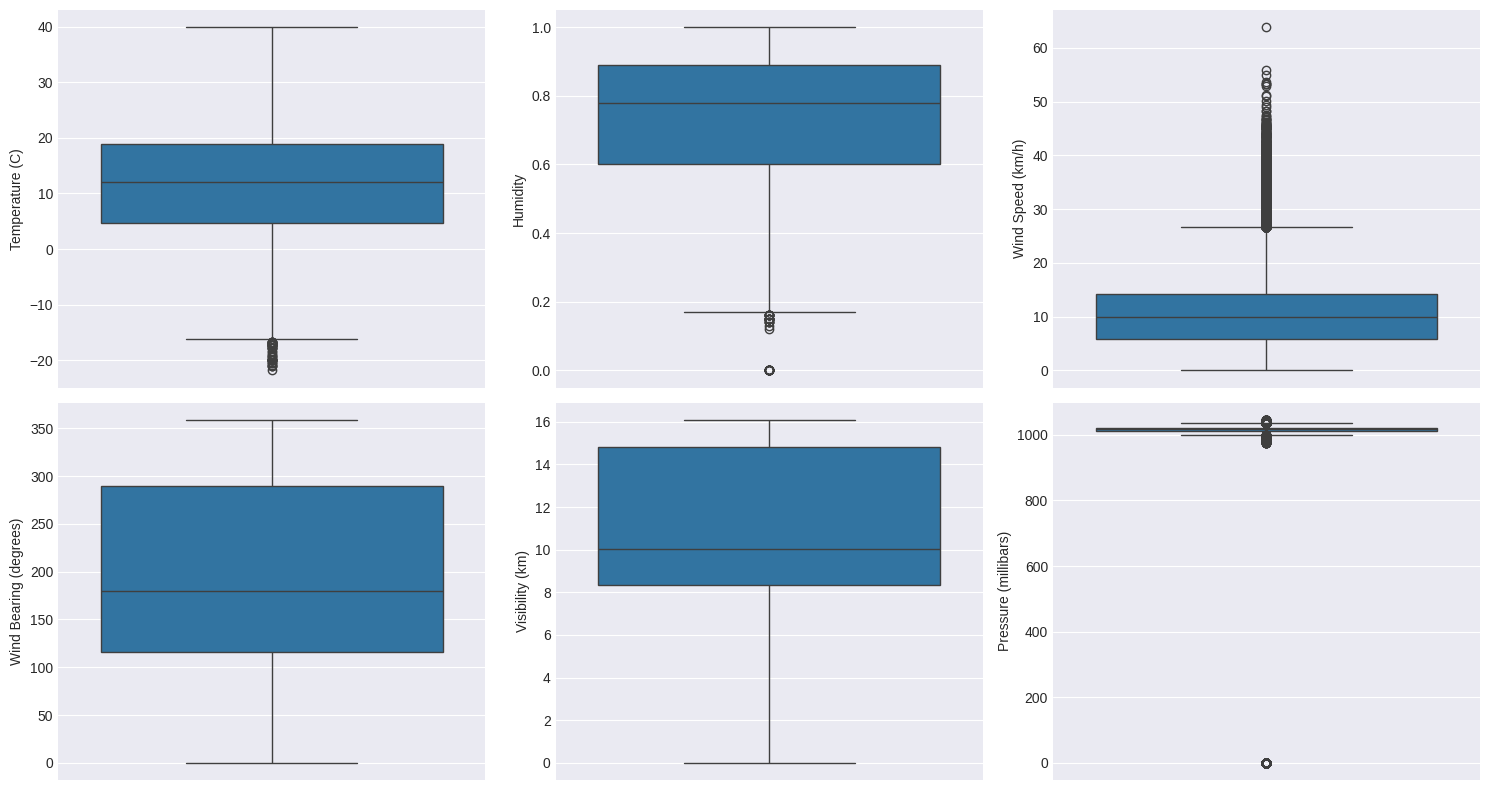

In [23]:
fig, axes = plt.subplots(2, 3, figsize = (15, 8))

axes = axes.ravel()

for count, col in enumerate(num_cols):
    ax = axes[count]
    sns.boxplot(data = data_df, y = col, ax = ax)

plt.tight_layout()

In [24]:
data_df.columns

Index(['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)', 'Daily Summary', 'datetime'],
      dtype='object')

<Axes: xlabel='Formatted Date'>

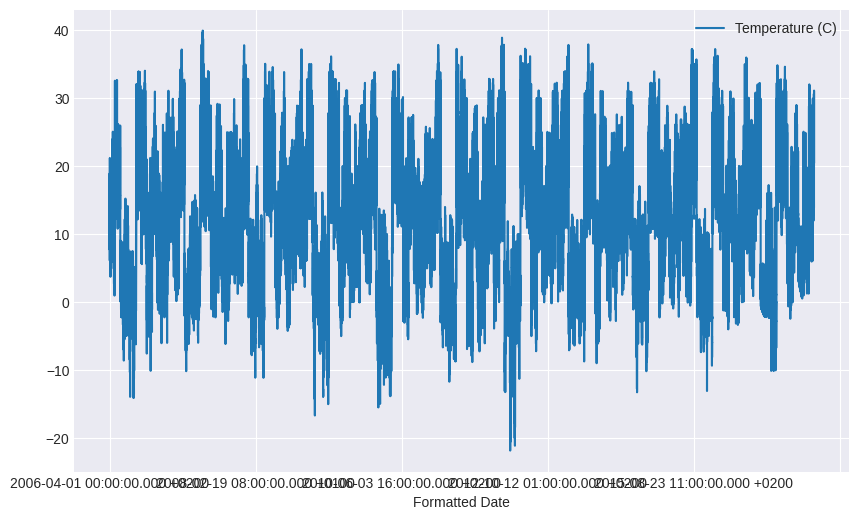

In [25]:
fig, ax = plt.subplots()
data_df.plot(x = 'Formatted Date', y = 'Temperature (C)', ax = ax)

<Axes: >

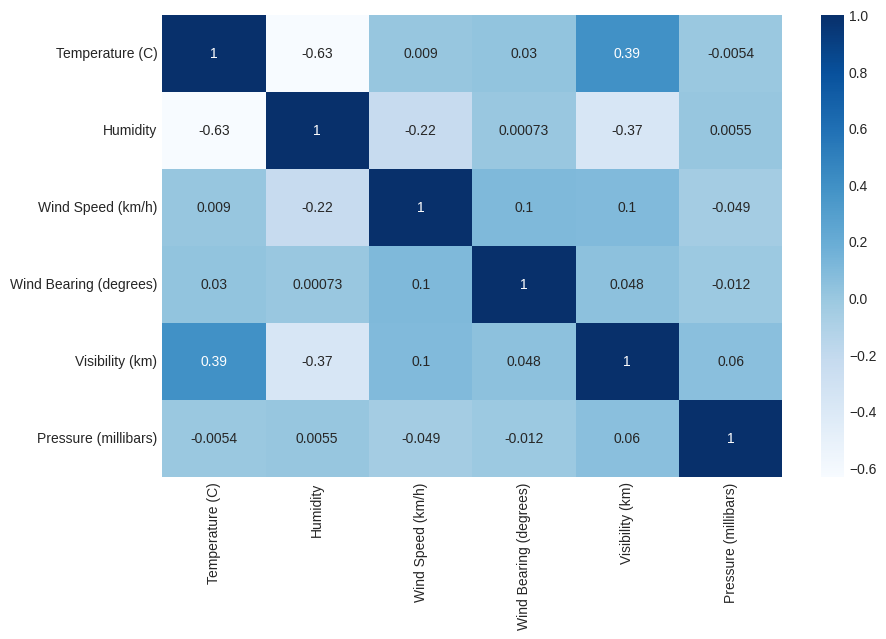

In [26]:
sns.heatmap(data_df[num_cols].corr(), annot = True, cmap = 'Blues')

In [36]:
tmp_df = data_df[['Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Visibility (km)', 'datetime']]
tmp_df = tmp_df.sort_values('datetime', axis = 0, ascending = True)
tmp_df = tmp_df.reset_index(drop = True)
tmp_df = tmp_df.rename({'Temperature (C)' : 'temp',
                          'Humidity': 'hum',
                          'Wind Speed (km/h)' : 'wind',
                          'Visibility (km)' : 'vis'
                          }, axis = 1)
tmp_df.head()

,temp,hum,wind,vis,datetime
0,0.577778,0.89,17.1143,9.9820,2005-12-31 23:00:00+00:00
1,1.161111,0.85,16.6152,9.9015,2006-01-01 00:00:00+00:00
2,1.666667,0.82,20.2538,9.9015,2006-01-01 01:00:00+00:00
3,1.711111,0.82,14.4900,9.9015,2006-01-01 02:00:00+00:00
4,1.183333,0.86,13.9426,9.9015,2006-01-01 03:00:00+00:00


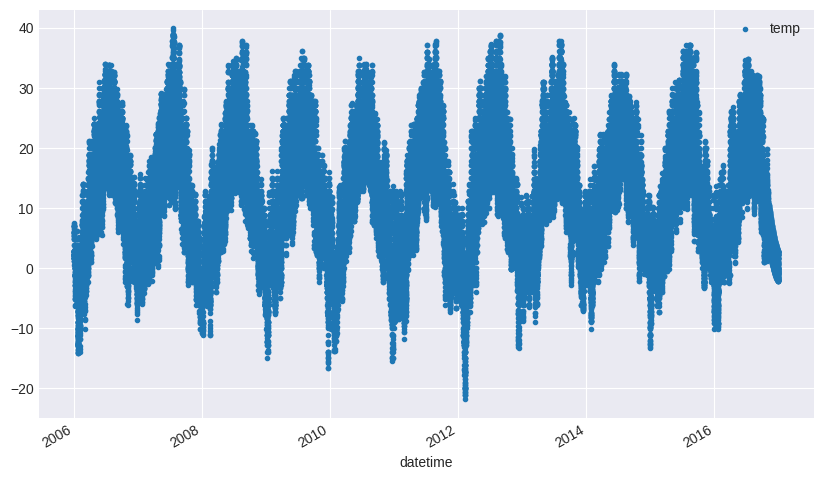

In [39]:
ax = tmp_df.plot(x = 'datetime', y = 'temp', style = '.');

In [40]:
h_units = 100
input_shape = (1, 10000)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape = input_shape))
model.add(tf.keras.layers.SimpleRNN(units = h_units,
                                    activation = 'tanh'))
model.add(tf.keras.layers.Dense(1,
                                    activation = 'linear'))

In [41]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)             │ (None, 100)                 │       1,010,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,010,201 (3.85 MB)

 Trainable params: 1,010,201 (3.85 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# for ax in model.get_weights():
    # print(ax.shape)
print(f'Wax = {model.get_weights()[0].shape}')
print(f'Waa = {model.get_weights()[1].shape}')
print(f'ba = {model.get_weights()[2].shape}')
print(f'Way = {model.get_weights()[3].shape}')
print(f'by = {model.get_weights()[4].shape}')

Wax = (10000, 100)
Waa = (100, 100)
ba = (100,)
Way = (100, 1)
by = (1,)


In [45]:
time_step = 24
tmp_df.shape[0]/time_step

y_idx = np.arange(time_step, tmp_df.shape[0], time_step)
y_df  = tmp_df.iloc[y_idx][['datetime', 'temp']]
y_df

,datetime,temp
24,2006-01-01 23:00:00+00:00,5.422222
48,2006-01-02 23:00:00+00:00,1.694444
72,2006-01-03 23:00:00+00:00,2.200000
96,2006-01-04 23:00:00+00:00,1.666667
120,2006-01-05 23:00:00+00:00,1.805556
...,...,...
96336,2016-12-27 02:00:00+00:00,-1.627778
96360,2016-12-28 02:00:00+00:00,-1.677778
96384,2016-12-29 02:00:00+00:00,-1.727778
96408,2016-12-30 02:00:00+00:00,-1.777778


In [46]:
tmp_df = tmp_df.iloc[range(len(y_df)*time_step)]
# x_df = temp_df.iloc[y_idx]
tmp_df.shape

(96432, 5)

In [47]:
# Reshape to match number of rows in y_df
x_temp = np.reshape(tmp_df['temp'].values, (y_df.shape[0], time_step))
x_hum = np.reshape(tmp_df['hum'].values, (y_df.shape[0], time_step))
x_wind = np.reshape(tmp_df['wind'].values, (y_df.shape[0], time_step))
x_vis = np.reshape(tmp_df['vis'].values, (y_df.shape[0], time_step))
x_temp.shape, y_df.shape

((4018, 24), (4018, 2))

In [48]:
# Remove last column
x_temp = x_temp[:, :23]
x_hum = x_hum[:, :23]
x_wind = x_wind[:, :23]
x_vis = x_vis[:, :23]
x_temp.shape

(4018, 23)

In [49]:
# x[0], y_df.head(1)

NameError: name 'x' is not defined

In [50]:
x_data = np.stack((x_temp, x_hum, x_vis, x_wind))
x_data = np.reshape(x_data, (x_temp.shape[0], x_temp.shape[1], 4))
x_data.shape

(4018, 23, 4)

In [51]:
split = int(y_df.shape[0] * (1 - TEST_SIZE))
split

3214

In [52]:
x_train = x_data[: split]
x_test = x_data[split : ]
y_train = y_df['temp'].values[: split]
y_test = y_df['temp'].values[split:]

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((3214, 23, 4), (804, 23, 4), (3214,), (804,))

In [53]:
h_units = 256
input_shape = (time_step - 1, x_train.shape[2])
initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape = input_shape))
model.add(tf.keras.layers.SimpleRNN(units = h_units,
                                    kernel_initializer = initializer,
                                    activation = 'tanh'))
model.add(tf.keras.layers.Dense(1,
                                kernel_initializer = initializer,
                                activation = 'linear'))

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)             │ (None, 256)                 │          66,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,073 (262.00 KB)

 Trainable params: 67,073 (262.00 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
model.compile(optimizer = "adam",
              loss = 'mean_squared_error',
              metrics = [tf.keras.metrics.RootMeanSquaredError(name = 'RMSE')])

history = model.fit(x_train, y_train,
                    validation_data = [x_test, y_test],
                    batch_size = BATCH_SIZE,
                    verbose = 2,
                    epochs = EPOCHS)

Epoch 1/30
101/101 - 4s - 38ms/step - RMSE: 8.3823 - loss: 70.2623 - val_RMSE: 7.2662 - val_loss: 52.7970
Epoch 2/30
101/101 - 2s - 21ms/step - RMSE: 8.1825 - loss: 66.9534 - val_RMSE: 7.3541 - val_loss: 54.0832
Epoch 3/30
101/101 - 4s - 37ms/step - RMSE: 8.2495 - loss: 68.0547 - val_RMSE: 7.2327 - val_loss: 52.3117
Epoch 4/30
101/101 - 3s - 33ms/step - RMSE: 8.1373 - loss: 66.2162 - val_RMSE: 7.5531 - val_loss: 57.0488
Epoch 5/30
101/101 - 2s - 21ms/step - RMSE: 8.2073 - loss: 67.3599 - val_RMSE: 7.3395 - val_loss: 53.8684
Epoch 6/30
101/101 - 3s - 25ms/step - RMSE: 8.0928 - loss: 65.4934 - val_RMSE: 7.3805 - val_loss: 54.4721
Epoch 7/30
101/101 - 2s - 24ms/step - RMSE: 8.0508 - loss: 64.8153 - val_RMSE: 7.4290 - val_loss: 55.1904
Epoch 8/30
101/101 - 3s - 34ms/step - RMSE: 7.9930 - loss: 63.8885 - val_RMSE: 7.4826 - val_loss: 55.9901
Epoch 9/30
101/101 - 2s - 19ms/step - RMSE: 7.9084 - loss: 62.5433 - val_RMSE: 7.4247 - val_loss: 55.1267
Epoch 10/30
101/101 - 2s - 20ms/step - RMSE: 7

In [55]:
hist_df = pd.DataFrame(history.history)
display(hist_df.head())

,RMSE,loss,val_RMSE,val_loss
0,8.382258,70.262260,7.266154,52.796993
1,8.182504,66.953369,7.354127,54.083187
2,8.249530,68.054749,7.232682,52.311695
3,8.137335,66.216217,7.553066,57.048809
4,8.207310,67.359932,7.339510,53.868416


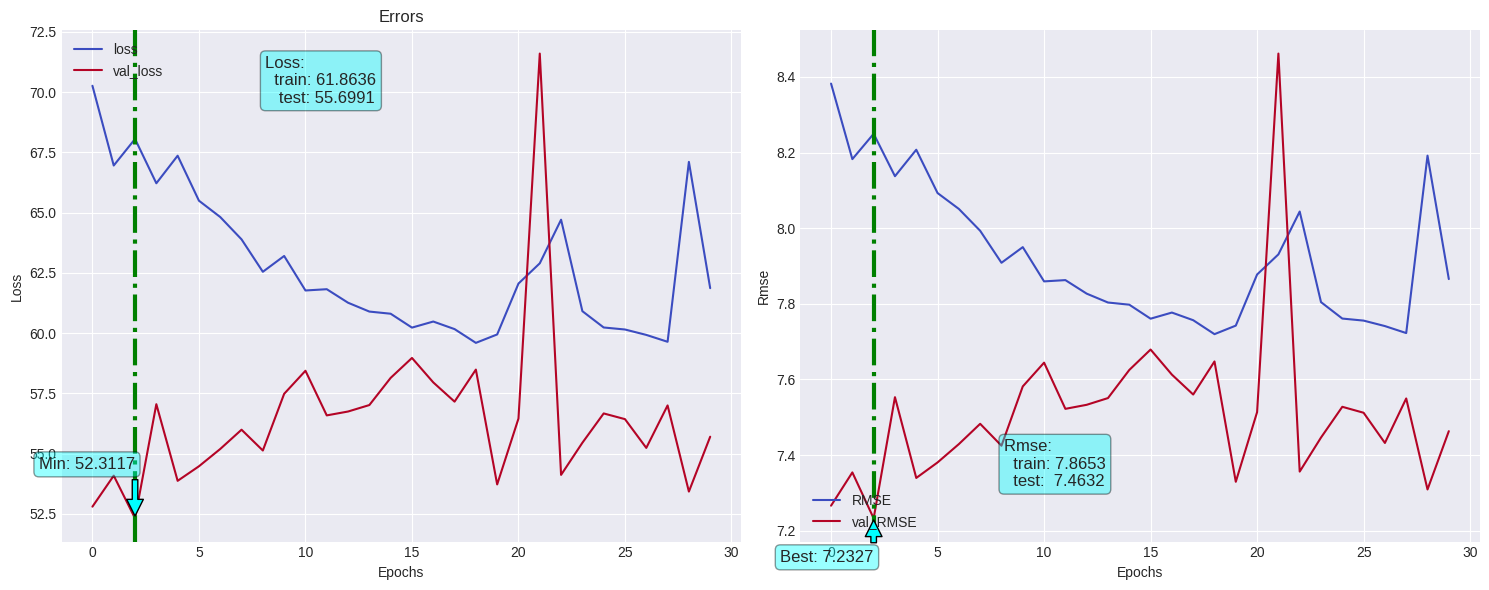

In [56]:
fn_plot_tf_hist(hist_df = hist_df)

In [59]:
y_tr_pred = model.predict(x_train)
y_ts_pred = model.predict(x_test)
y_pred = np.append(y_tr_pred, y_ts_pred)

res_df = y_df.copy()
res_df['pred'] = y_pred
res_df.head()

101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


,datetime,temp,pred
24,2006-01-01 23:00:00+00:00,5.422222,10.059216
48,2006-01-02 23:00:00+00:00,1.694444,8.816135
72,2006-01-03 23:00:00+00:00,2.200000,8.450389
96,2006-01-04 23:00:00+00:00,1.666667,4.405884
120,2006-01-05 23:00:00+00:00,1.805556,6.565093


<Axes: xlabel='datetime'>

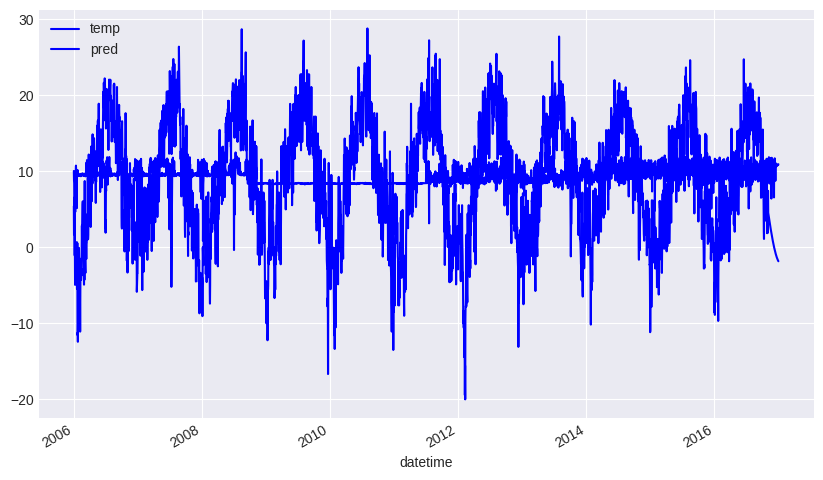

In [60]:
res_df.plot(x = 'datetime', y = ['temp', 'pred'], color = 'blue')